In [2]:
import sys
sys.path.append(sys.path[0] + "/..")

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, clear_output, HTML, Javascript
display(HTML("<style>.container { width:100% !important; }</style>"))

In [62]:
import pandas as pd
import numpy as np

df = pd.read_csv("../experiments/data/interim/DIJA-2006-2018-clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

In [73]:
df.head()

,Open,High,Low,Close,Name
Date,,,,,
2006-01-03,77.76,79.35,77.24,79.11,MMM
2006-01-04,79.49,79.49,78.25,78.71,MMM
2006-01-05,78.41,78.65,77.56,77.99,MMM
2006-01-06,78.64,78.90,77.64,78.63,MMM
2006-01-09,78.50,79.83,78.46,79.02,MMM


In [275]:
from hedgepy.core import HedgeFrame
from memoization import cached

hf = HedgeFrame(df, 'Name')
_90d_dcor_network = hf.dcor(rolling_window=90).network()
# @cached
# def build_correlation_matrix_time_series(df, ticker_col_name, rolling_window):
#     hf = HedgeFrame(df, ticker_col_name)
#     numpy_time_series_dict = hf.build_correlation_matrix_time_series(rolling_window=rolling_window)
#     return numpy_time_series_dict
    

# _90d_dcor_network = hf.build_dcor_network_time_series(rolling_window=90)

In [71]:
# from hedgepy.core import build_correlation_network
# import networkx as nx

# @cached
# def build_global_clustering_time_series(nx_time_series, corr_threshold=None):
#     nx_network_time_series = {
#         time_series: build_correlation_network(df_dcor, corr_threshold=corr_threshold)
#         for time_series, df_dcor in nx_time_series.items()
#     }
    
#     global_clustering_ts = {
#         timestamp: nx.average_clustering(df, weight='weight') for timestamp, df in nx_network_time_series.items()
#     }
    
#     return global_clustering_ts

In [65]:
# frame = build_correlation_matrix_time_series(df, 'Name', rolling_window=90)

In [69]:
global_clustering_ts = build_global_clustering_time_series(frame)
df_clustering = pd.DataFrame.from_dict(global_clustering_ts, orient='index')\
        .rename(columns={0: '90d_global_clustering_coefficient'})

In [38]:
df_clustering.head()

,90d_global_clustering_coefficient
2006-05-12,0.453719
2006-05-15,0.472583
2006-05-16,0.474465
2006-05-17,0.469718
2006-05-18,0.466833


In [ ]:
import networkx as nx

def average_communicability_betweenness(G):
    cbc = nx.communicability_betweenness_centrality(G)
    average_cbc = np.mean(list(cbc.values()))
    return average_cbc

def average_degree_centrality(G):
    dc = nx.degree_centrality(G)
    avg_dc = np.mean(list(dc.values()))
    return avg_dc

def average_eigenvector_centrality(G):
    ec = nx.eigenvector_centrality(G, weight='weight')
    avg_ec = np.mean(list(ec.values()))
    return avg_ec

nx_time_series = {
    timestamp: nx.average_clustering(dcor_network, weight='weight') 
     for timestamp, dcor_network in _90d_dcor_network.frame.items()
}

# nx_time_series = {
#     timestamp: average_eigenvector_centrality(dcor_network) 
#      for timestamp, dcor_network in _90d_dcor_network.items()
# }
    
df_clustering = pd.DataFrame.from_dict(nx_time_series, orient='index')\
    .rename(columns={0: '90d_global_clustering_coefficient'})

In [216]:
test = df_clustering.to_numpy()
df_test = pd.DataFrame(test)
df_test.columns = df_clustering.columns
df_test.index = df_clustering.index

In [217]:
df_test.head()

,90d_global_clustering_coefficient
2006-05-12,0.037676
2006-05-15,0.033724
2006-05-16,0.017135
2006-05-17,0.057661
2006-05-18,0.085318


In [220]:
df_clustering.to_csv('../experiments/data/processed/DIJA-2006-2008-90d-dcor-nx-clustering-soft-thresh.csv')

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()

In [17]:
df_dija_index = pd.read_csv('../experiments/data/raw/DIJA-index-2006-2018.csv')

In [18]:
df_dija_index['Date'] = pd.to_datetime(df_dija_index['Date'])

In [19]:
df_dija_index.set_index('Date', inplace=True)

In [95]:
dft = pd.read_csv('../experiments/data/processed/DIJA-2006-2008-90d-dcor-nx-clustering-0.33corr-thresh.csv')
dft = dft.rename(columns={'Unnamed: 0': 'Date'})
dft['Date'] = pd.to_datetime(dft['Date'])
dft.set_index('Date', inplace=True)

In [28]:
test = df_dija_index['Close'].pct_change().rolling(30).std()

Text(0, 0.5, 'DIJA Index')

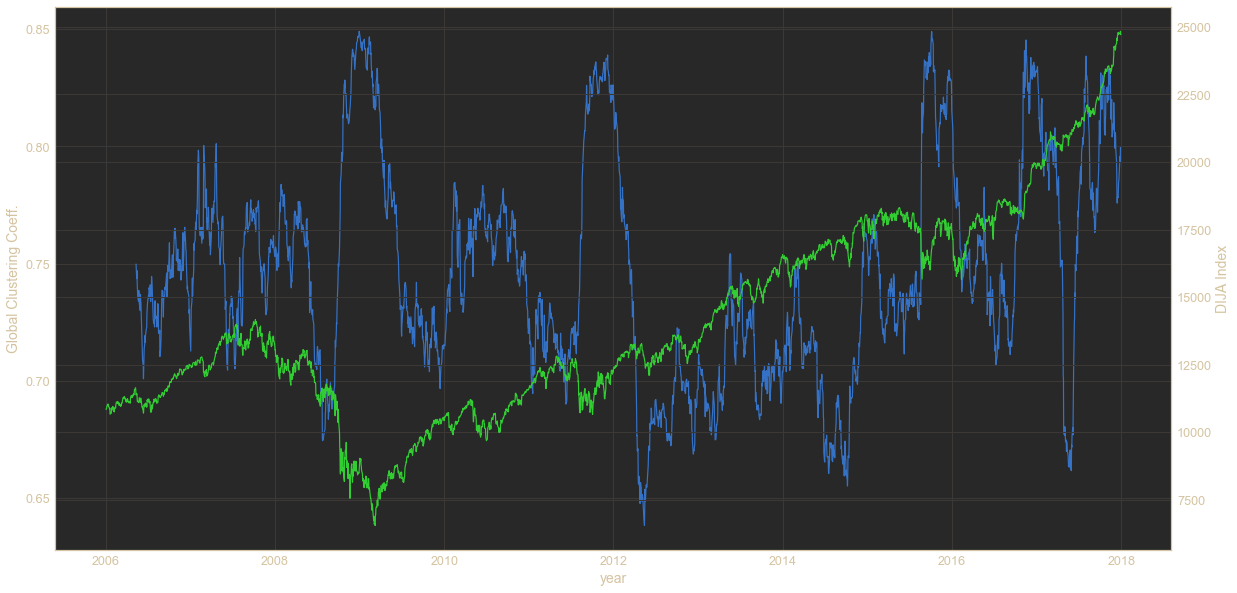

In [221]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_clustering)
ax.set_xlabel("year", fontsize=14)
ax.set_ylabel("Global Clustering Coeff.", fontsize=14)

ax2 = ax.twinx()
ax2.plot(df_dija_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)

In [240]:
dft['90d_global_clustering_coefficient'].corr(df_dija_index['Close'])

0.014423525893521631

In [222]:
dft = df_clustering

In [205]:
dft_pos = dft.pct_change()[dft.pct_change()['90d_global_clustering_coefficient'] >=0]

In [335]:
# dft_pos.columns = ['crisis_coeff']
# dft_pos.dropna(inplace=True)

In [249]:
dft['crisis_coeff'] = dft[['90d_global_clustering_coefficient']].pct_change()

In [194]:
dft = dft.replace([np.inf, -np.inf], np.nan)

In [255]:
dft.dropna(inplace=True)

In [250]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import math

def optimize_OneClassSVM(X, n):
    print('searching for optimal hyperparameters...')
    nu = np.linspace(start=1e-5, stop=1e-2, num=n)
    gamma = np.linspace(start=1e-6, stop=1e-3, num=n)
    opt_diff = 1.0
    opt_nu = None
    opt_gamma = None
    for i in range(len(nu)):
        for j in range(len(gamma)):
            classifier = OneClassSVM(kernel="rbf", nu=nu[i], gamma=gamma[j])
            classifier.fit(X)
            label = classifier.predict(X)
            p = 1 - float(sum(label == 1.0)) / len(label)
            diff = math.fabs(p - nu[i])
            if diff < opt_diff:
                opt_diff = diff
                opt_nu = nu[i]
                opt_gamma = gamma[j]
    return opt_nu, opt_gamma

In [251]:
data = dft[['crisis_coeff']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled).dropna()

opt_nu, opt_gamma = optimize_OneClassSVM(data, n=20)

searching for optimal hyperparameters...


In [270]:
opt_nu

0.006845263157894737

In [253]:
opt_gamma

5.357894736842106e-05

In [271]:
p = 1/len(dft)

In [272]:
#train OneClassSVM
model = OneClassSVM(nu=p, kernel="rbf", gamma=opt_gamma)
model.fit(data)
anomalies = pd.Series(model.predict(data), index=dft.index)

In [273]:
dft['anomaly'] = anomalies

2020-04-27 21:04:58,622 [24056] WARNING  matplotlib.legend:1282: [JupyterRequire] No handles with labels found to put in legend.


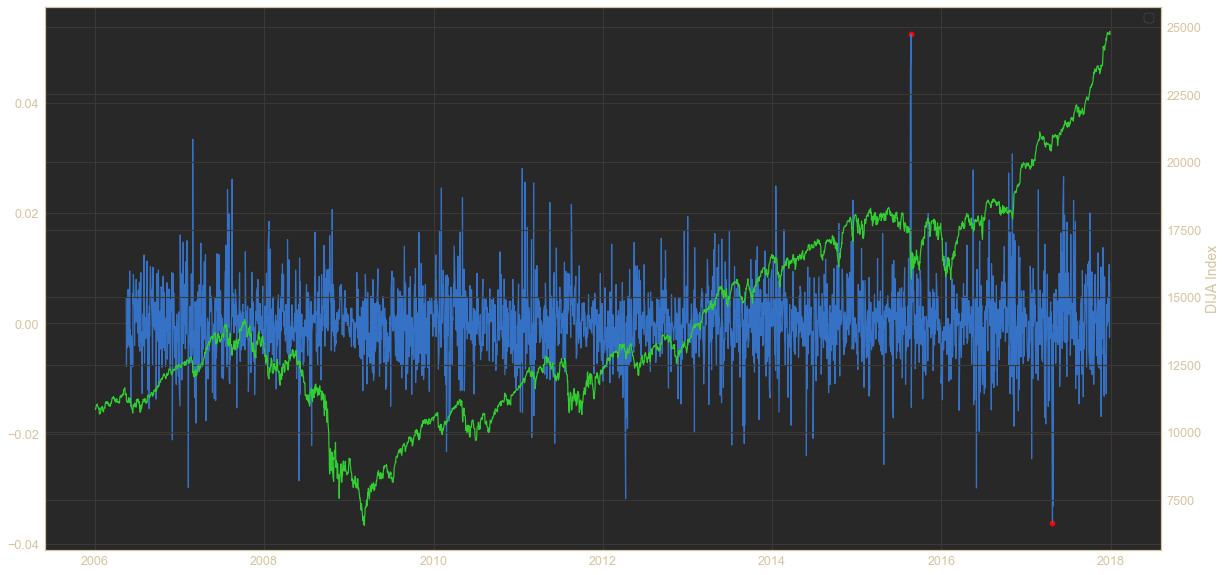

In [274]:
a = dft.loc[dft['anomaly'] == -1]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft.index, dft['crisis_coeff'], label='Normal')
ax.scatter(a.index, a['crisis_coeff'], color='red', label='Anomaly')

ax2 = ax.twinx()
ax2.plot(df_dija_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
plt.legend()

In [268]:
dft[(dft['anomaly'] == -1)] 

,90d_global_clustering_coefficient,crisis_coeff,anomaly
2007-02-08,0.770339,-0.029788,-1
2007-02-27,0.786405,0.033466,-1
2007-07-27,0.732667,0.024345,-1
2007-08-16,0.750556,0.026202,-1
2008-05-30,0.729087,-0.028546,-1
2008-07-24,0.675746,-0.022173,-1
2010-02-04,0.763672,0.024614,-1
2010-02-26,0.753470,-0.023310,-1
2011-01-19,0.714159,0.028160,-1
2011-01-31,0.726777,0.025696,-1


2020-04-27 13:00:11,511 [24056] WARNING  matplotlib.legend:1282: [JupyterRequire] No handles with labels found to put in legend.


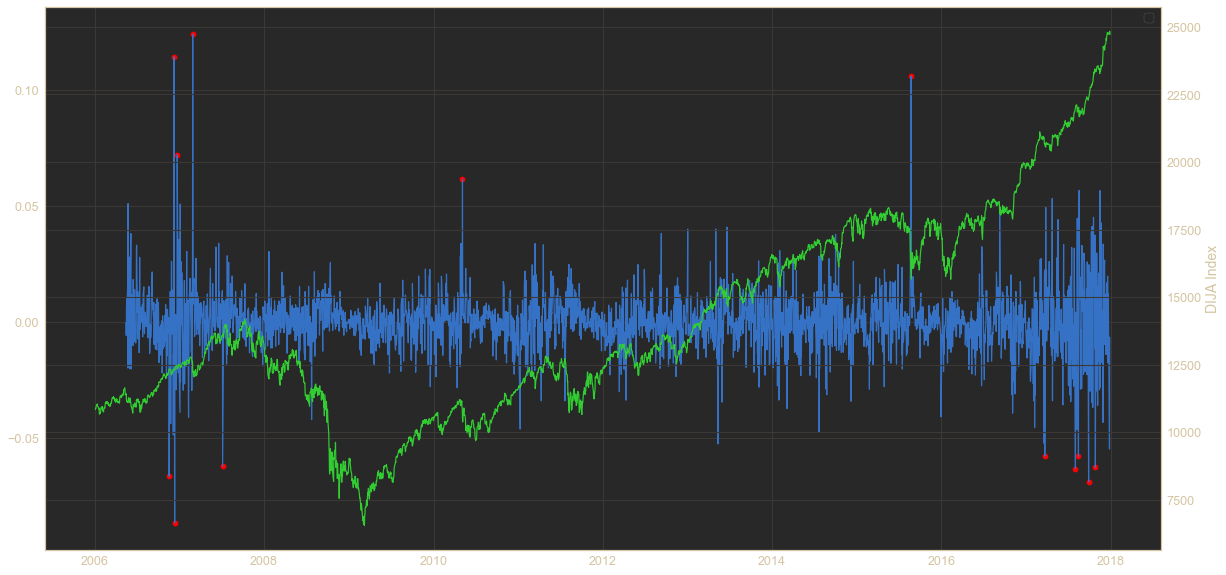

In [103]:
a = dft.loc[dft['anomaly'] == -1, ['crisis_coeff']]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft.index, dft['crisis_coeff'], label='Normal')
ax.scatter(a.index, a['crisis_coeff'], color='red', label='Anomaly')

ax2 = ax.twinx()
ax2.plot(df_dija_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
plt.legend()

In [104]:
dft[(dft['anomaly'] == -1)] 

,90d_global_clustering_coefficient,crisis_coeff,anomaly
Date,,,
2006-11-17,0.398503,-0.066472,-1
2006-12-08,0.406639,0.114262,-1
2006-12-11,0.371487,-0.086444,-1
2006-12-22,0.371663,0.072017,-1
2007-02-27,0.384500,0.124067,-1
2007-07-06,0.488553,-0.062124,-1
2010-05-06,0.602965,0.061589,-1
2015-08-24,0.651363,0.105971,-1
2017-03-23,0.330982,-0.057740,-1


In [265]:
import ipyhc as hc

dija_index_series = hc.build.series(df_dija_index[['Close']])
df_clustering_series = hc.build.series(dft[['90d_global_clustering_coefficient']])

In [266]:
df_clustering_series[0]['yAxis'] = 1

In [267]:
options = {
    'credits': {'enabled': True,
                'text': 'Source: XXX Flow Strategy & Solutions.',
                'href': 'http://www.example.com'},
    'exporting': {'enabled': True},
    'chart': {'zoomType': 'xy'},
    'plotOptions': {'series': {'compare': 'percent'}},
    'legend': {'enabled': True,
               'layout': 'horizontal',
               'align': 'center',
               'maxHeight': 100},
    'tooltip': {'enabled': True,
                'valueDecimals': 5,
                'pointFormat': '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.change}%)<br/>',
                'positioner': "function(labelWidth, labelHeight, point) {\n    var roundUp100 = function(d) { return 100*Math.floor(d/100); },\n        labelWidth = roundUp100(labelWidth),\n        chart = window.charts['__uuid__'];\n\n    var tooltipX, tooltipY;\n        var testX = (point.plotX + labelWidth * 0.7 > chart.plotWidth / 2) && (point.plotX - labelWidth * 0.7 < chart.plotWidth / 2);\n        var testY = point.plotY < labelHeight * 0.7;\n\n    if (testX && testY) {\n                tooltipX = chart.plotLeft + (chart.plotWidth - labelWidth) / 2;\n        tooltipY = chart.plotTop + chart.plotHeight - labelHeight;\n    } else {\n                tooltipX = chart.plotLeft + (chart.plotWidth - labelWidth) / 2;\n        tooltipY = chart.plotTop;\n    }\n\n    return {\n        x: tooltipX,\n        y: tooltipY\n    };\n}\n\n"},
    'title': {'text': 'Time series plotted with HighStock'},
    'subtitle': {'text': 'Transparent access to the underlying js lib'},
    'yAxis': [
        {
            'gridLineWidth': 1.0,
            'gridLineDashStyle': 'Dot',
        },
        {
            'gridLineWidth': 1.0,
            'gridLineDashStyle': 'Dot',
            'title': {
                'text': '% change'
            }
        }
    ],
    'xAxis': {
        'gridLineWidth': 1.0, 
        'gridLineDashStyle': 'Dot'},
}

chart = hc.Chart(height=600, width=1200, stock = True, options = options, data = dija_index_series + df_clustering_series)
chart

Chart(height='600px', stock=True, width='1200px')